# Support Vector Machine (SVM)
This notebook includes predictive modeling of social ratings using Support Vector Machines (SVMs) and grid search cross validation.

---

### Content:

- **1) Load Packages & Data**
- **2) Image Preprocessing**
    - a) Stratified train-test split
    - b) Conversion to grayscale
    - c) Mean-centering
    - d) Flattening
- **3) PCR for Modeling**
- **4) SVR using Grid Search CV**
- **5) Model Evaluation**
- **6) Summary of Results**

---

# 1) Load packages & Data

In [1]:
# Load basic packages

import pandas as pd
import numpy as np
import os, os.path

import seaborn as sns
import matplotlib.pyplot as plt

#plt.style.use('seaborn-white')  
sns.set_style("white")

In [2]:
# choose type of X and y values for modeling 

data_path = '/Users/kacha/nf-ds/nf_capstone/data/'
y_name = 'yT'    # select from:  yT, yF, yS, yA, yE, yI
X_name = 'Xf'    # select from:  Xr, Xs, Xp, Xf (all uncentered)

y = np.load(data_path + y_name + '.npy')
X = np.load(data_path + X_name + '.npy')

X.shape, y.shape

((2222, 224, 224, 3), (2222,))

---
# 2) Image Preprocessing

### a) Stratified train-test split

In [3]:
# load indices for stratified train-test-split

skfold_path = '/Users/kacha/nf-ds/nf_capstone/data/skfold_1/'
train_idx = np.load(skfold_path + y_name + '_train_raw_indices.npy')
test_idx = np.load(skfold_path + y_name + '_test_indices.npy')

In [4]:
# make train/test split based on loaded indices

X_train = X[train_idx]
X_test = X[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1888, 224, 224, 3), (334, 224, 224, 3), (1888,), (334,))

In [5]:
# delete unsplit data to free up RAM
del X, y

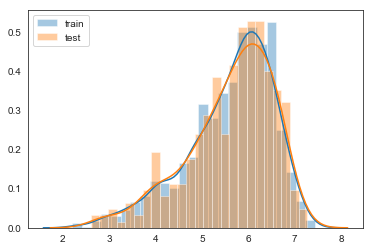

In [6]:
# check stratification for y

sns.distplot(y_train, bins=25)
sns.distplot(y_test, bins=25)
plt.legend(labels=['train','test'], loc='upper left');

In [ ]:
# plot example images with min/max ratings in train and test set
# Note: output not shown in GitHub because of license agreement for face images

plt.figure(figsize=(9,4))

# train data with min and max rating
plt.subplot(141)
idx = y_train.argmin()
plt.imshow(X_train[idx])  # /255.0)
plt.title('train - min\n{:.2f}'.format(y_train[idx]));

plt.subplot(142)
idx = y_train.argmax() 
plt.imshow(X_train[idx]) # /255.0)
plt.title('train - max\n{:.2f}'.format(y_train[idx]));

# test data with min and max rating
plt.subplot(143)
idx = y_test.argmin()
plt.imshow(X_test[idx])  # /255.0)
plt.title('test - min\n{:.2f}'.format(y_test[idx]));

plt.subplot(144)
idx = y_test.argmax()
plt.imshow(X_test[idx])  # /255.0)
plt.title('test - max\n{:.2f}'.format(y_test[idx]));
plt.tight_layout();

### b) Conversion to grayscale

In [9]:
# make grayscale images from rgb images
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
# https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert

def rgb2gray(X):
    return np.dot(X[...,:3], [0.2989, 0.5870, 0.1140])

X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)

X_train_gray.shape, X_test_gray.shape

((1888, 224, 224), (334, 224, 224))

In [ ]:
# plot example images with min/max ratings in train and test set
# Note: output not shown in GitHub because of license agreement for face images

plt.figure(figsize=(9,4))

# train data with min and max rating
plt.subplot(141)
idx = y_train.argmin()
plt.imshow(X_train_gray[idx], cmap=plt.get_cmap('gray'))  # /255.0)
plt.title('train - min\n{:.2f}'.format(y_train[idx]));

plt.subplot(142)
idx = y_train.argmax() 
plt.imshow(X_train_gray[idx], cmap=plt.get_cmap('gray')) # /255.0)
plt.title('train - max\n{:.2f}'.format(y_train[idx]));


# test data with min and max rating
plt.subplot(143)
idx = y_test.argmin()
plt.imshow(X_test_gray[idx], cmap=plt.get_cmap('gray'))  # /255.0)
plt.title('test - min\n{:.2f}'.format(y_test[idx]));

plt.subplot(144)
idx = y_test.argmax()
plt.imshow(X_test_gray[idx], cmap=plt.get_cmap('gray'))  # /255.0)
plt.title('test - max\n{:.2f}'.format(y_test[idx]));
plt.tight_layout();

### c) Mean-centering

In [11]:
# take the mean of trainings set for mean-centering of train/test set later

X_mean = np.mean(X_train, axis=0)
X_mean_gray = np.mean(X_train_gray, axis=0)

X_mean.shape, X_mean_gray.shape

((224, 224, 3), (224, 224))

In [12]:
# write functions to center X using mean of training data:

# for colored images
def center_X(X):
    return X - X_mean

def decenter_X(X):
    return X + X_mean

# for gray images
def center_X_gray(X):
    return X - X_mean_gray

def decenter_X_gray(X):
    return X + X_mean_gray

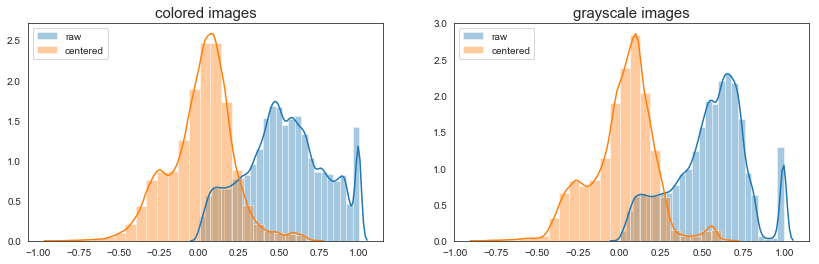

In [15]:
# plot distribution of pixel values for raw and mean-centered images

plt.figure(figsize=(14,4))

# for colored images
plt.subplot(121)
sns.distplot(X_train[:5].ravel(), bins=25)
sns.distplot(center_X(X_train[:5]).ravel(), bins=25)
plt.legend(labels=['raw','centered'], loc='upper left')
plt.title('colored images', size=15);

# for grayscale images
plt.subplot(122)
sns.distplot(X_train_gray[:5].ravel(), bins=25)
sns.distplot(center_X_gray(X_train_gray[:5]).ravel(), bins=25)
plt.legend(labels=['raw','centered'], loc='upper left')
plt.title('grayscale images', size=15);

### d) Flattening

In [16]:
# flatten centered image arrays for PCA/SVR (cf = centered & flat)
# see: https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

# for colored images
X_train_cf = center_X(X_train).reshape((X_train.shape[0], -1))
X_test_cf = center_X(X_test).reshape((X_test.shape[0], -1))

# for grayscale images
X_train_gray_cf = center_X_gray(X_train_gray).reshape((X_train_gray.shape[0], -1))
X_test_gray_cf = center_X_gray(X_test_gray).reshape((X_test_gray.shape[0], -1))

X_train_cf.shape, X_train_gray_cf.shape, X_test_cf.shape, X_test_gray_cf.shape

((1888, 150528), (1888, 50176), (334, 150528), (334, 50176))

---
# 3) PCR for modeling

**Some notes about PCA for modeling:**

Each image contains [224 x 224] or over 50,000 pixels (per color channel). While we could use each pixel value as a feature, it is more effective to use some sort of preprocessor like principal component analysis (PCA) to extract more meaningful features and feed these features into our support vector machine (SVM) regressor. We will do this by packaging the PCA and the SVM into a single pipeline (see below).


In the case of images, one common heuristic is to choose the number of extracted compontents so as to **retain 99%** of the variance. Depending on the application, if you are willing to incur some additional error, values in the **90-98% range** are also sometimes used. When you describe to others how you applied PCA, saying that you chose k to retain 95% of the variance will also be a much more easily interpretable description than saying that you retained 120 (or whatever other number of) components.

from: http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/

In [28]:
# check how many components are extracted if we set 'explain_variance' to different values

from sklearn.decomposition import PCA

explain_variance = 0.90
pca = PCA(n_components=explain_variance, svd_solver='auto', whiten=True, random_state=0) 

pca.fit(X_train_cf, y_train)        # for rgb images
#pca.fit(X_train_gray_cf, y_train)  # for gray images
print(pca.n_components_)
#pca.explained_variance_ratio_.cumsum()

296


**Number of extracted components with rgb images: (same for whiten=True or False):**
- with 0.80:  39 components
- with 0.90: 123 components
- with 0.95: 296 components

**Number of extracted components with grayscale images: (same for whiten=True or False):**
- with 0.80:  34 components
- with 0.90: 105 components
- with 0.95: 247 components

In [ ]:
# plot explained variance ratio over components
'''
plt.plot(range(len(pca.explained_variance_ratio_)), 
               pca.explained_variance_ratio_);
''';

In [ ]:
# check value for gamma when 'scale' keyword is used below
# see formula: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html --> 1 / (n_features * X.var())
'''
pca = PCA(n_components=0.90, svd_solver='auto', whiten=True, random_state=0) 
pca.fit(X_train_cf)
X_transformed = pca.transform(X_train_cf)
print(X_transformed.shape)
print('X var:', X_transformed.var())
print('n features:', pca.n_components_)
print('scale:', 1 / ( pca.n_components_ * X_transformed.var() )) # = 0.008
''';

---
# 4) SVR using Grid Search CV

**Some notes about Grid Search CV:**

We use a grid search cross-validation to explore combinations of parameters. Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model. 

If the returned optimal values do not fall toward the middle of our grid, but at the edges, we will to expand the grid to make sure we have found the true optimum.

- https://scikit-learn.org/stable/modules/svm.html
- https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression

In [14]:
# import packages for grid search CV

from sklearn.svm import SVR 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [ ]:
# fitting model WITH grid search
'''
# select parameter values for grid search
param_grid = {'svr__C': [0.5, 1, 2.5],
              'svr__gamma': ['scale', 0.001, 0.005]}

# initialize models and run grid search
pca = PCA(n_components=0.90, svd_solver='auto', whiten=True, random_state=0)  
svr = SVR(kernel='rbf')
model = make_pipeline(pca, svr)
grayscale = False

grid = GridSearchCV(model, param_grid, cv=5, verbose=2)  #n_jobs=1

if grayscale:
    %time grid.fit(X_train_gray_flat, y_train)
else:
    %time grid.fit(X_train_flat, y_train)

# get best model parameters
print(grid.best_params_)
model = grid.best_estimator_
''';

In [15]:
# fitting model WITHOUT grid search

model_name = 's29'
pca = PCA(n_components=0.90, svd_solver='auto', whiten=True, random_state=0)  
svr = SVR(kernel='rbf', C=1, gamma='scale')
model = make_pipeline(pca, svr)
grayscale = False

if grayscale:
    model.fit(X_train_gray_cf, y_train)
else:
    model.fit(X_train_cf, y_train)

In [16]:
# save trained model with pickle
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

import pickle

model_file = '_'.join([model_name, X_name, y_name + '.sav'])
models_dir = '/Users/kacha/nf-ds/nf_capstone/models/'
pickle.dump(model, open(models_dir + model_file, 'wb'))
print('model saved to: ' + models_dir + model_file)

model saved to: /Users/kacha/nf-ds/nf_capstone/models/s29_Xf_yT.sav


In [ ]:
# load model from .sav file

# loaded_model = pickle.load(open(models_dir + filename, 'rb'))
# loaded_model.get_params

---
# 5) Model Evaluation

In [17]:
# make predictions with trained model

if grayscale:
    y_pred_test = model.predict(X_test_gray_cf)
    y_pred_train = model.predict(X_train_gray_cf)
else:
    y_pred_test = model.predict(X_test_cf)
    y_pred_train = model.predict(X_train_cf)
    
print(y_pred_test.shape, y_pred_train.shape)

(334,) (1888,)


In [18]:
# function to make dataframe with model statistics (RMSE, MAE, PC)

def make_df_model_eval(y_pred_test, y_pred_train):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    from scipy.stats import pearsonr

    n_train = y_train.shape[0]
    RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    MAE_train = mean_absolute_error(y_train, y_pred_train)
    PC_train = 100*pearsonr(y_train, y_pred_train)[0]

    n_test = y_test.shape[0]
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    MAE_test = mean_absolute_error(y_test, y_pred_test)
    PC_test = 100*pearsonr(y_test, y_pred_test)[0]

    df_model_eval = pd.DataFrame([[n_train, RMSE_train, MAE_train, PC_train],
                                  [n_test, RMSE_test, MAE_test, PC_test]],
                                   index=['train', 'test'],
                                   columns=['n_samples', 'RMSE', 'MAE', 'PC'])
    return df_model_eval

In [19]:
df_model_eval = make_df_model_eval(y_pred_test, y_pred_train)
with pd.option_context('display.float_format', '{:,.3f}'.format):
    display(df_model_eval)

,n_samples,RMSE,MAE,PC
train,1888,0.394,0.243,92.973
test,334,0.730,0.583,62.247


In [20]:
# save model evaluation dataframe

eval_file = '_'.join([model_name, X_name, y_name, 'eval.csv'])
df_model_eval.to_csv(models_dir + eval_file, index=False)
print('evaluation dataframe saved to: ' + models_dir + eval_file)

evaluation dataframe saved to: /Users/kacha/nf-ds/nf_capstone/models/s29_Xf_yT_eval.csv


In [21]:
# write function to show scatter plot (pred vs. true) for train and test set

def model_scatter_hist(y_test, y_pred_test, y_train, y_pred_train):

    fig = plt.figure(figsize=(8,6))
    
    sns.scatterplot(y_train, y_pred_train, color='blue', label='train')
    sns.scatterplot(y_test, y_pred_test, color='red', label='test')
    plt.xlabel('true rating', size=12)
    plt.ylabel('predicted rating', size=12);
    plt.ylim((1,9))
    plt.xlim((1,9))
    plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim(), ls="--", c='gray')
    plt.show();

    fig = plt.figure(figsize=(8,4))
    sns.distplot(y_test, bins=25, label='true')
    sns.distplot(y_pred_test, bins=25, label='predicted')
    plt.xlim((1,9))
    plt.legend()
    plt.show();

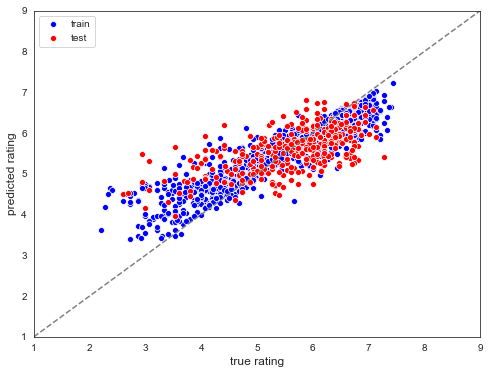

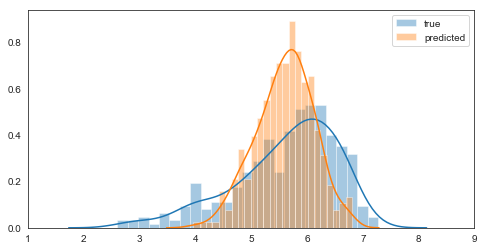

In [22]:
# show scatter plot (pred. vs. true) for current model
model_scatter_hist(y_test, y_pred_test, y_train, y_pred_train)

In [23]:
# write function to show min/max predictions

def plot_min_max_predictions(y_pred_test, n=5):

    y_pred_min = y_pred_test.argsort()[:n]
    y_pred_max = y_pred_test.argsort()[-n:]

    fig, ax = plt.subplots(2,n,figsize=(3*n,7))

    for p, i in enumerate(y_pred_min, start=1):
        plt.subplot(2,n,p)
        plt.imshow(X_test[i])  #/255.0)
        plt.title('true: {:.2f}\npredicted: {:.2f}'.format(y_test[i], y_pred_test[i]))
        plt.axis('off');

    for p, i in enumerate(y_pred_max, start=n+1):
        plt.subplot(2,n,p)
        plt.imshow(X_test[i])  #/255.0)
        plt.title('true: {:.2f}\npredicted: {:.2f}'.format(y_test[i], y_pred_test[i]))
        plt.axis('off');

    plt.show();

In [ ]:
# plot min/max predictions
# Note: output not shown in GitHub because of license agreement for face images

plot_min_max_predictions(y_pred_test, n=5)

In [ ]:
# plot some of the test images along with their predicted values
# Note: output not shown in GitHub because of license agreement for face images

fig, ax = plt.subplots(4, 6, figsize=(13,10))
plt.subplots_adjust(hspace=0.7)

for i, axi in enumerate(ax.flat):

    if grayscale:
        axi.imshow(X_test_gray[i],  # decenter_X_gray(X_test_gray_cf[i].reshape(224, -1)
                   cmap=plt.get_cmap('gray'))
    else:
        axi.imshow(X_test[i])       # decenter_X(X_test_cf[i].reshape(224, -1, 3))
        
    axi.set(xticks=[], yticks=[])
    axi.set_title('true: {}\npred: {}'.format(y_pred_test[i].round(2), y_test[i].round(2)),
                       color='black' if (abs(y_pred_test[i] - y_test[i]) < 1.0) else 'red')
    
fig.suptitle('True and predicted ratings - Red labels show difference > 1.0', size=14);

---
# 6) Summary of Results

**Summary of Results:**

model | X | y | n_comp | whiten | C grid | gamma grid | C best | gamma best | kernel | train | test
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
s01 | Xs, gray  | yT | 150 | True  | [1, 5, 10, 50]  | [0.0001, 0.0005, 0.001, 0.005] | 1  | .005  | rgb | 83% | 54%
s02 | Xs, gray  | yT | 150 | True  | [0.01, 0.1, 1]  | [0.001, 0.005, 0.01, 0.05] | 1  | .005  | rbf | 83%   | 54%
s03 | Xsc, gray | yT | .95 | False | [0.1, 1, 10]    | [0.001, 0.005, 0.01]       | 10 | .001  | rbf | 99.6% | 47.1%
s04 | Xsc, gray | yT | .95 | False | [10, 100, 1000] | [0.00001, 0.0001, 0.001]   | 10 | .0001 | rbf | 79.6% | 50.6%
s05 | Xsc, gray | yT | .95 | True  | no grid         | no grid                    | 10 | .0001 | rbf | 62.3% | 48.3%
s06 | Xsc, gray | yT | .75*| False | no grid         | no grid                    | 10 | .0001 | rbf | 46.5% | 30.1%
s07 | Xsc, rgb  | yT | .95 | False | [0.1, 1, 10, 100] | ['scale']                | 1  | scale | rbf | 85.0% | 51.0%
s08 | Xsc, rgb  | yT | .95 | True  | no grid         | no grid                    | 1  | scale | rbf | 93.3% | 55.4%
s09 | Xsc, rgb  | yT | .99 | True  | [0.5, 1, 5]     | [0.0001, 0.001, 0.01]      | 5  | .001  | rbf | 99.7% | 47.0%
s10 | Xsc, rgb  | yT | .99 | True  | no grid         | no grid                    | .1 | scale | rbf | 80.0% | 41.7%
s11 | Xsc, rgb  | yT | .90 | True  | no grid         | no grid                    | 1  | scale | rbf | 91.6% | 55.9%
s12 | Xsc, rgb  | yT | .95 | True  | [0.5, 0.75, 1, 2.5] | ['scale', 0.001, 0.005] | -  | - | rbf | - | -
s13 | Xrc, rgb  | yT | .90 | True  | no grid         | no grid                    | 1  | scale | rbf | 92.1% | 57.6%
s14 | Xr**, rgb | yT | .90 | True  | no grid         | no grid                    | 1  | scale | rbf | 92.1% | 57.6%
s15 | Xrc, rgb  | yA | .90 | True  | no grid         | no grid                    | 1  | scale | rbf | 89.3% | 57.9%
s16 | Xrc, rgb  | yT | .90 | True  | [0.5, 1, 2.5]   | ['scale', 0.001, 0.005]  | 2.5 | scale | rbf | 97.7% | 57.2%
s17 | Xrc, rgb  | yT | .90 | True  | no grid         | no grid                  | 1  |  -  | linear | 58.5% | 49.7%
s18 | Xrc, rgb  | yT | .90 | True  | no grid         | no grid                  | 1  | scale | poly | 84.1% | 43.6%
s19 | Xfc, rgb  | yT | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 93.0% | 62.2%
s20 | Xfc, rgb  | yT | .90 | False | no grid         | no grid                  | 1  | scale | rbf  | 96.3% | 33.5%
s21 | Xf2c, rgb | yT | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 93.1% | 60.1%
s22 | Xrc, rgb  | yT | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 92.0% | 56.9%
s23 | Xfc, rgb  | yF | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 93.0% | 64.4%
s24 | Xfc, rgb  | yS | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 92.4% | 66.0%
s25 | Xfc, rgb  | yA | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 90.1% | 60.7%
s26 | Xfc, rgb  | yE | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 93.4% | 51.9%
s27 | Xfc, rgb  | yI | .90 | True  | no grid         | no grid                  | 1  | scale | rbf  | 92.4% | 52.9%
s28 | Xfc, rgb  | yI | .95 | True  | no grid         | no grid                  | 1  | scale | rbf  | 94.0% | 50.6%


<br><br>

**Final models:**

model | X | y | n_comp | whiten |  C | gamma | kernel | train | test
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
s19 | Xfc, rgb  | yT | .90 | True  |  1  | scale | rbf  | 93.0% | 62.2%
s23 | Xfc, rgb  | yF | .90 | True  |  1  | scale | rbf  | 93.0% | 64.4%
s24 | Xfc, rgb  | yS | .90 | True  |  1  | scale | rbf  | 92.4% | 66.0%
s25 | Xfc, rgb  | yA | .90 | True  |  1  | scale | rbf  | 90.1% | 60.7%
s26 | Xfc, rgb  | yE | .90 | True  |  1  | scale | rbf  | 93.4% | 51.9%
s27 | Xfc, rgb  | yI | .90 | True  |  1  | scale | rbf  | 92.4% | 52.9%


\* only 18 components extracted<br>
\** exactly same results as s13 (with Xrc)<br>
c: image array was centered before PCA (although PCA in sklearn centers features by default, see \**)

---